### Imports:
<p>Bibliotecas para analise exploratoria dos dados de temperatura.</p>

In [1]:
import pandas as pd #manipular dataframe
import numpy as np #manipular arrays
import matplotlib.pyplot as plt #criar graficos
import seaborn as sns #criar graficos
from statistics import mode
import warnings; warnings.filterwarnings('ignore') #remove avisos pandas

### Importar base de dados

<p>
df recebe o arquivo GlobalLandTemperaturesByCity.csv
</p>

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByCity.csv')
df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E
9,1744-08-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


### Verificação de dados que necessita tratamentos
<br>
<li>Dados nulos;</li>
<li>Tamanho do dataframe;</li>
<li>Tipo das colunas;</li>
<li>Nomes dos paises.</li>

In [3]:
print(df.isnull().sum(), end='\n\n')
print(df.shape, end='\n\n')
print(df.info(), end='\n\n')
print(df['Country'].unique())

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

(8599212, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None

['Denmark' 'Turkey' 'Kazakhstan' 'China' 'Spain' 'Germany' 'Nigeria'
 'Iran' 'Russia' 'Canada' "Côte D'Ivoire" 'United Kingd

### Tratamento de Dados
<br>
<li>Conversão tipo coluna data de string para datetime;</li>
<li>Remover valores nulos do DataFrame;</li>
<li>Criar coluna: Decada;</li>
<li>Criar DataFrame Decada com media, maxima e minima temperatura por década.</li>

In [4]:
df['dt'] = pd.to_datetime(df['dt']) #Col dt string para datetime
df.dropna(subset=['AverageTemperature','AverageTemperatureUncertainty'], inplace=True) #drop nulos
df['decada'] = df['dt'].apply(lambda x: int(str(x)[:3] + '0')) # criar coluna decada atravez da coluna data

# criar dataframe decada (media, maximo, minimo):
decada = df.groupby('decada', as_index=False).agg({'AverageTemperature':['mean',max,min]})

# prints:
'-'*50,df.shape,'-'*50,df.dtypes,'-'*50,decada.shape,'-'*50,decada.dtypes

('--------------------------------------------------',
 (8235082, 8),
 '--------------------------------------------------',
 dt                               datetime64[ns]
 AverageTemperature                      float64
 AverageTemperatureUncertainty           float64
 City                                     object
 Country                                  object
 Latitude                                 object
 Longitude                                object
 decada                                    int64
 dtype: object,
 '--------------------------------------------------',
 (28, 4),
 '--------------------------------------------------',
 decada                        int64
 AverageTemperature  mean    float64
                     max     float64
                     min     float64
 dtype: object)

### Densidade

<p>Distribuição da temperatura média</p>
<p style="text-align: justify">
Podemos verificar que temos a média menor do que a mediana, e a mediana é menor do que a moda (Mo > Md > x̅), o que indica que a distribuição dos dados é assimétrica e com cauda à esquerda.
</p>

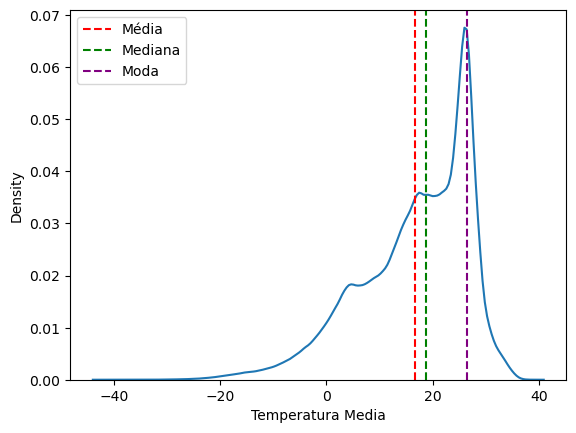

In [5]:
sns.kdeplot(x=df['AverageTemperature'])

plt.axvline(np.mean(df['AverageTemperature']), color='red', linestyle='--', label='Média')
plt.axvline(np.median(df['AverageTemperature']), color='green', linestyle='--', label='Mediana')
plt.axvline(mode(df['AverageTemperature'].to_list()), color='purple', linestyle='--', label='Moda')
plt.xlabel('Temperatura Media')
plt.legend()
plt.show()


### Analise de Evolução da Temperatura por década

<p style="text-align: justify">
A análise realizada indica que, ao longo da década em questão, a temperatura média aumentou. No entanto, observou-se que a temperatura mínima ao longo da década foi diminuindo, indicando uma mudança na distribuição de temperaturas. Além disso, a variação de temperaturas ao longo do tempo aumentou, indicando uma maior instabilidade na temperatura média. Esses resultados apontam para uma mudança significativa no clima ao longo da década, que pode ter implicações importantes para a saúde e o meio ambiente.
<p/>

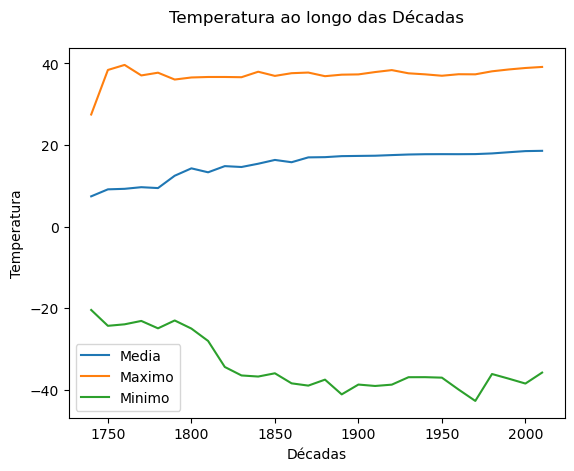

In [6]:
# lineplot
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[1]], label='Media')
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[2]], label='Maximo')
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[3]], label='Minimo')
plt.title('Temperatura ao longo das Décadas\n')
plt.ylabel('Temperatura')
plt.xlabel('Décadas')

plt.show()

### Analise de Outliers

#### Disperção de valores por década

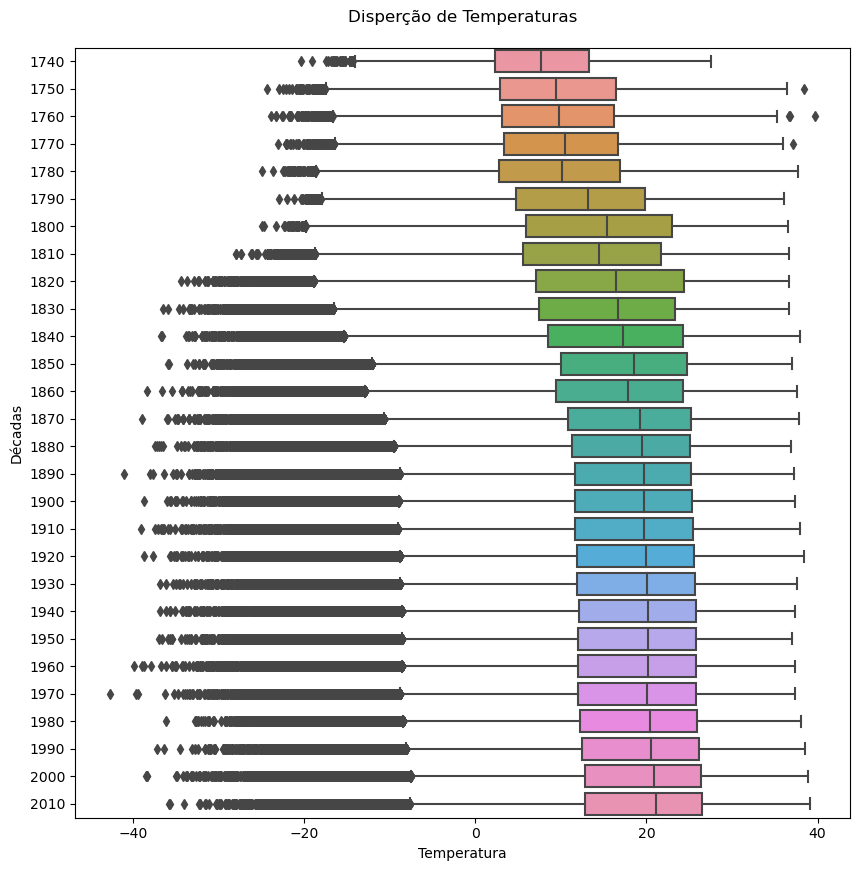

In [7]:
decada = df.groupby('decada', as_index=False).agg({'AverageTemperature':['mean',max,min]})

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x=df['AverageTemperature'], y=df['decada'], orient='h') #boxplot na horizontal

plt.title('Disperção de Temperaturas\n')
plt.xlabel('Temperatura')
plt.ylabel('Décadas')
plt.show()

In [8]:
#calcular quartis
quartil_1 = df.groupby('decada', as_index=False)['AverageTemperature'].quantile(.25)
quartil_1.rename(columns={'AverageTemperature':'Q1'}, inplace=True)

quartil_3 = df.groupby('decada', as_index=False)['AverageTemperature'].quantile(.75)
quartil_3.rename(columns={'AverageTemperature': 'Q3'}, inplace=True)

#unir dados de quartis ao dataframe original + criar coluna flag outliers acima ou abaixo
df = df.merge(quartil_1, how='left', on='decada').merge(quartil_3, how='left', on='decada')
df['outliers'] = np.where(df['AverageTemperature']<=df['Q1'], 'outlier baixo',
                         np.where(df['AverageTemperature']>=df['Q3'], 'outlier alto', '-'))

# verificar se outliers compoem 25% dos dados
print(f"Q1: {np.mean(df['outliers'] == 'outlier baixo')}")
print(f"Q3: {np.mean(df['outliers'] == 'outlier alto')}")

Q1: 0.2500196112194147
Q3: 0.2500413474935647


#### Paises com mais participações em outliers baixos (Q1)

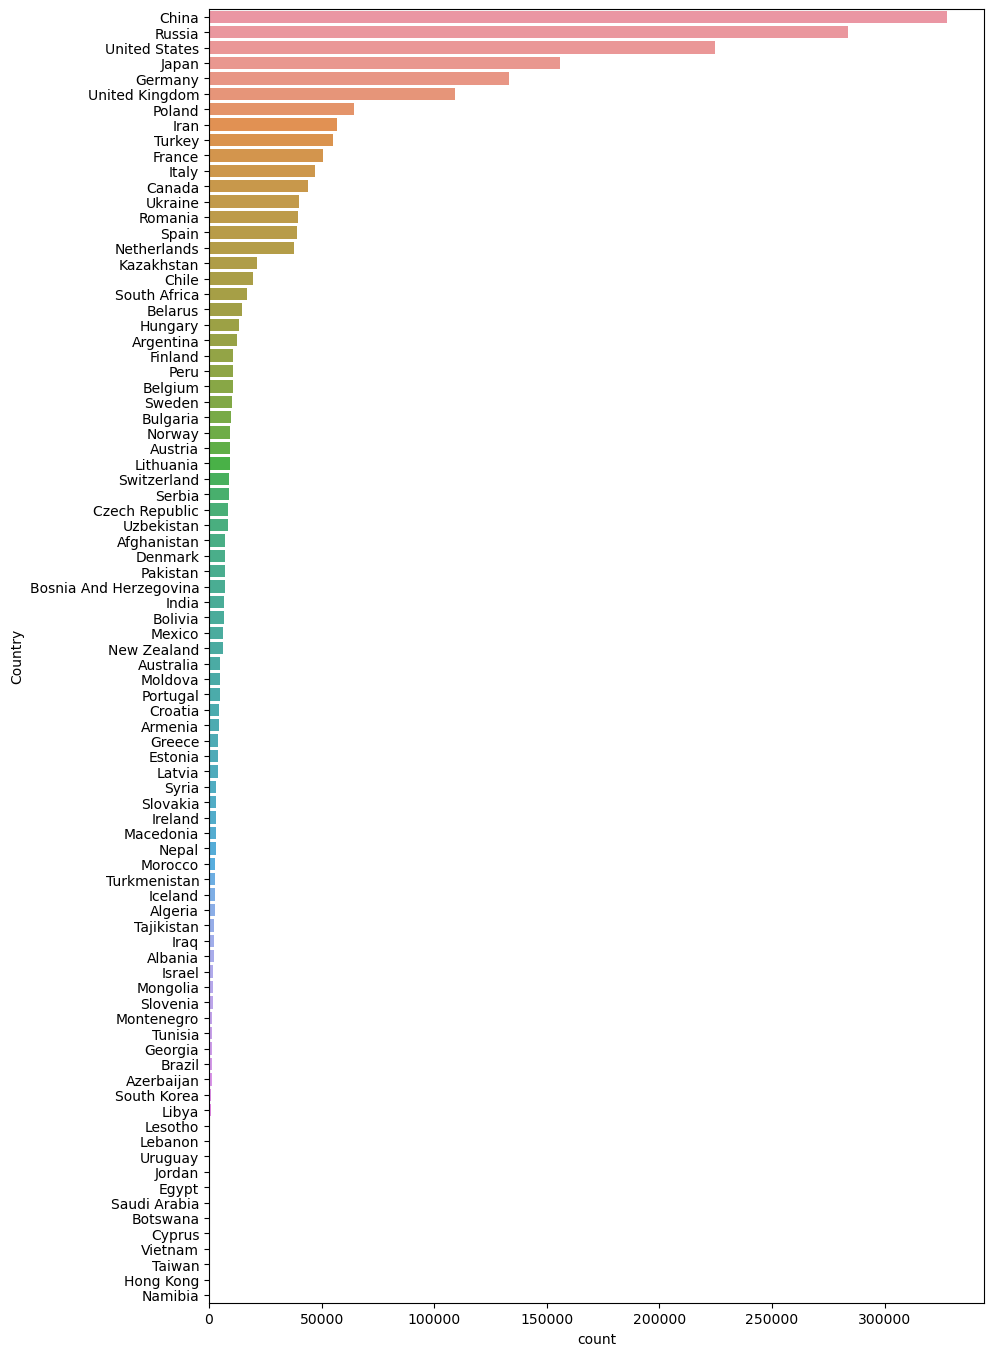

In [9]:
q1 = df.loc[df['outliers'] == 'outlier baixo']
q1['count'] = 1
q1 = q1.groupby('Country', as_index=False)['count'].sum()
q1.sort_values(by='count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, q1.shape[0]/5))
sns.barplot(x=q1['count'], y=q1['Country'], orient='h')
plt.show()

#### Paises com mais participações em outliers alto (Q3)

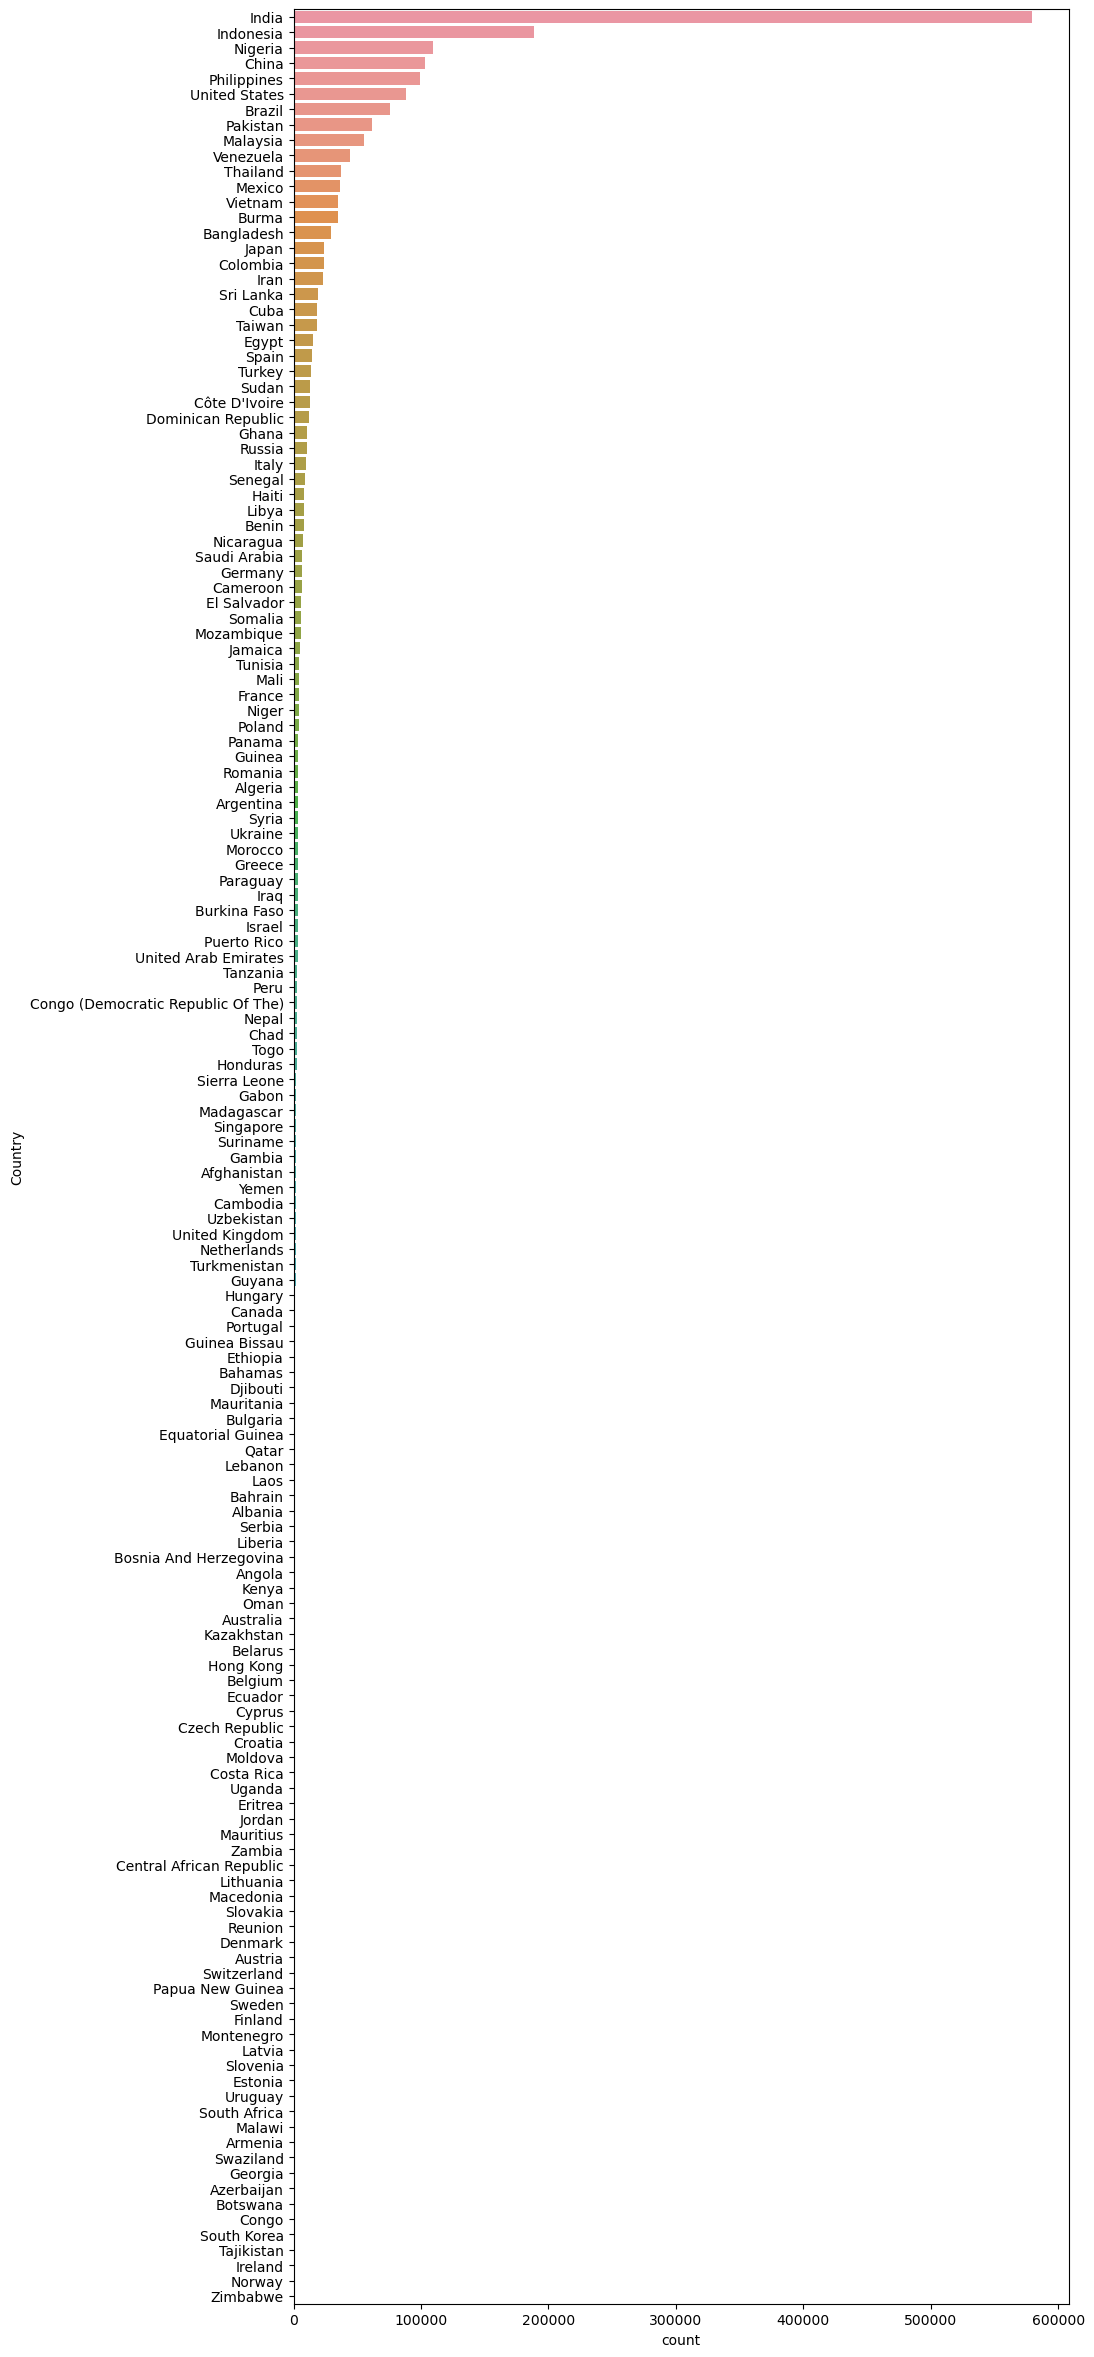

In [10]:
q3 = df.loc[df['outliers'] == 'outlier alto']
q3['count'] = 1
q3 = q3.groupby('Country', as_index=False)['count'].sum()
q3.sort_values(by='count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, q3.shape[0]/5))
sns.barplot(x=q3['count'], y=q3['Country'], orient='h')
plt.show()

### Proximas analises:

**Análise de outliers:** Identifique cidades com temperaturas médias extremamente altas ou baixas e faça uma análise mais aprofundada dessas cidades. Isso pode ajudá-lo a entender melhor os fatores que afetam a temperatura média em diferentes locais.

**Variação da temperatura média ao longo do tempo:** Plote um gráfico de linha que mostre como a temperatura média varia ao longo do tempo para cada cidade. Isso pode ajudá-lo a identificar se há um padrão sazonal ou uma tendência geral no aumento ou diminuição da temperatura média ao longo do tempo.

**Correlação entre temperatura média e localização geográfica:** Plote um mapa que mostre a temperatura média de cada cidade em relação à sua localização geográfica. Isso pode ajudá-lo a identificar se existe alguma relação entre a latitude ou longitude da cidade e sua temperatura média.

**Comparação de temperaturas médias entre regiões geográficas:** Agrupe as cidades por regiões geográficas (por exemplo, América do Norte, Europa, Ásia, etc.) e compare as temperaturas médias entre essas regiões. Isso pode ajudá-lo a identificar padrões de temperatura diferentes entre diferentes regiões.

**Análise de correlação entre temperatura média e outras variáveis:** Identifique outras variáveis que possam estar relacionadas à temperatura média, como altitude, umidade, densidade populacional, entre outras, e faça uma análise de correlação para entender como essas variáveis estão relacionadas à temperatura média.